In [1]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image 
import numpy as np
import dataset_utils
import importlib
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier 
from sklearn.preprocessing import StandardScaler

importlib.reload(dataset_utils)

<module 'dataset_utils' from '/home/fogliodicarta/Desktop/InsectClassification/dataset_utils.py'>

# Dati nostri

In [48]:
df = pd.read_csv('final_dataset.csv',index_col=0)
tform = transforms.Compose([transforms.Resize((64,64)),transforms.PILToTensor(),transforms.ConvertImageDtype(torch.float),transforms.Normalize(0.5,0.5)])
image_dataset = torchvision.datasets.ImageFolder("image_dataset/",transform=tform)
species2genus = dataset_utils.species_label_to_genus_label(df,image_dataset)
batch_size = 1000 
import random
import dataset_utils
img2dna = dataset_utils.get_imgs_bold_id(image_dataset,df)

nucleotides = df[['nucleotide','species_name','genus_name','processid','image_urls']]
colonna_dna = df.loc[:,"nucleotide"]
nucleotides.loc[:,'nucleotide'] = colonna_dna.apply(dataset_utils.one_hot_encoding)
random.seed(42)

X_train_1, X_test, y_train_1, y_test = dataset_utils.data_split(nucleotides,0.2,random_state=42)
#print(y_test)
train_data = X_train_1
train_data['species_name'] = y_train_1

X_train, X_validation, y_train, y_validation = dataset_utils.data_split(train_data,0.2,drop_labels=False,random_state=42)
train_indices, val_indices, test_indices = dataset_utils.image_splits_from_df(X_train,X_validation,X_test,image_dataset)

described_species_labels = np.array([image_dataset.targets[i] for i in train_indices])
described_species_labels = np.unique(described_species_labels)

In [49]:
max(list(species2genus.values()))

371

In [50]:
expanded_train_dna_features = torch.load('dna_train_features.pt')
expanded_train_dna_labels = torch.load('dna_train_labels.pt')
image_train_features = torch.load('img_train_features.pt')
image_train_labels= torch.load('img_train_labels.pt')
assert((image_train_labels == expanded_train_dna_labels).all())

In [51]:
expanded_val_dna_features = torch.load('dna_val_features.pt')
expanded_val_dna_labels = torch.load('dna_val_labels.pt')
image_val_features = torch.load('img_val_features.pt')
image_val_labels = torch.load('img_val_labels.pt')
assert((image_val_labels == expanded_val_dna_labels).all())

In [52]:
expanded_test_dna_features = torch.load('dna_test_features.pt')
expanded_test_dna_labels = torch.load('dna_test_labels.pt')
image_test_features = torch.load('img_test_features.pt')
image_test_labels = torch.load('img_test_labels.pt')
assert((image_test_labels == expanded_test_dna_labels).all())
n_classes = 1050

In [53]:
'''class InsectNet(torch.nn.Module):
    def __init__(self):
        super(InsectNet, self).__init__()
        #self.drop1 = nn.Dropout(p=0.7)
        self.linear1 = nn.Linear(3250,3000)
        self.act1 = nn.LeakyReLU()
        self.linear2 = nn.Linear(3000,2000)
        self.act2 = nn.LeakyReLU()
        self.linearHeadGenus = nn.Linear(2000,372)
        self.linearHeadSpecies = nn.Linear(2000,n_classes)
    def forward(self, x):
        #x = self.drop1(x)
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        x_species = self.linearHeadSpecies(x)
        x_genus = self.linearHeadGenus(x)
        x_species = torch.nn.functional.softmax(x_species)
        x_genus = torch.nn.functional.softmax(x_genus)
        return x_species,x_genus
'''
class InsectNet(torch.nn.Module):
    def __init__(self):
        super(InsectNet, self).__init__()
        self.dout = nn.Dropout(p=0.8)
        self.linear1 = nn.Linear(5298,372)
        self.act1 = nn.LeakyReLU()
        self.linear2 = nn.Linear(372,n_classes)
        self.act2 = nn.Softmax()
    def forward(self, x):
        x = self.dout(x)
        x = self.linear1(x)
        x_genus = torch.nn.functional.softmax(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        return x,x_genus

'''class InsectNet(torch.nn.Module):
    def __init__(self):
        super(InsectNet, self).__init__()
        self.dout0 = nn.Dropout()
        self.linear1 = nn.Linear(5298,5000)
        self.act1 = nn.LeakyReLU()
        self.dout1 = nn.Dropout()

        self.linearG = nn.Linear(5000,372)
        self.linearS = nn.Linear(5000,n_classes)
    def forward(self, x):
        x = self.dout0(x)
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dout1(x)
        x_species = self.linearS(x)
        x_genus = self.linearG(x)

        x_species = nn.functional.softmax(x_species)
        x_genus = nn.functional.softmax(x_genus)
        return x_species,x_genus

#species2genus = np.array(species2genus)'''

'class InsectNet(torch.nn.Module):\n    def __init__(self):\n        super(InsectNet, self).__init__()\n        self.dout0 = nn.Dropout()\n        self.linear1 = nn.Linear(5298,5000)\n        self.act1 = nn.LeakyReLU()\n        self.dout1 = nn.Dropout()\n\n        self.linearG = nn.Linear(5000,372)\n        self.linearS = nn.Linear(5000,n_classes)\n    def forward(self, x):\n        x = self.dout0(x)\n        x = self.linear1(x)\n        x = self.act1(x)\n        x = self.dout1(x)\n        x_species = self.linearS(x)\n        x_genus = self.linearG(x)\n\n        x_species = nn.functional.softmax(x_species)\n        x_genus = nn.functional.softmax(x_genus)\n        return x_species,x_genus\n\n#species2genus = np.array(species2genus)'

In [54]:
sorted_keys = sorted(species2genus.keys())
species2genus = np.array([species2genus[key] for key in sorted_keys])
print(species2genus)
species2genus = species2genus[...,np.newaxis]
species2genus.shape

[234 234 235 ...  44  44 311]


(1050, 1)

In [55]:
image_train_features.shape

torch.Size([13039, 2048])

In [56]:
image_train_labels.shape

torch.Size([13039])

In [57]:
expanded_train_dna_features.shape

torch.Size([13039, 3250])

In [58]:
expanded_train_dna_labels.shape


torch.Size([13039])

# CONTROLLARE STA ROBA DI TRAIN VAL PRIMA DELLO SCALER

In [59]:
is_train_val = False 
print("ATTENZIONE A STA ROBA NON DIMENTICARE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
complete_train_features = torch.cat((expanded_train_dna_features,image_train_features),dim=1)
complete_val_features = torch.cat((expanded_val_dna_features,image_val_features),dim=1)
complete_test_features = torch.cat((expanded_test_dna_features,image_test_features),dim=1)
if is_train_val:
    complete_train_features = torch.cat((complete_train_features,complete_val_features),dim=0)
    complete_val_features = complete_test_features
    image_train_labels = torch.cat((image_train_labels,image_val_labels),dim=0)
    image_val_labels = image_test_labels

scaler = StandardScaler()

complete_train_features_scaled = scaler.fit_transform(complete_train_features)
complete_val_features_scaled = scaler.transform(complete_val_features)

ATTENZIONE A STA ROBA NON DIMENTICARE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [60]:
complete_train_features_scaled.shape

(13039, 5298)

In [61]:
complete_val_features_scaled.shape

(6955, 5298)

In [62]:
from torch.utils.data import Dataset
class FeatureDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index].type(torch.LongTensor)
        
        #if self.transform:
        #    x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
        #    x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)
complete_train_features_scaled = torch.tensor(complete_train_features_scaled,dtype=torch.float)
complete_val_features_scaled = torch.tensor(complete_val_features_scaled,dtype=torch.float)

d_train = FeatureDataset(complete_train_features_scaled,image_train_labels)
d_val = FeatureDataset(complete_val_features_scaled,image_val_labels)

In [63]:
species2genus.min()
species2genus.max()

371

In [64]:
species2genus.shape

(1050, 1)

In [65]:
complete_train_features_scaled.shape

torch.Size([13039, 5298])

# Fitting model

In [66]:
from torch.utils.data import DataLoader
batch_size = 1000
train_loader = DataLoader(d_train,shuffle=True,batch_size = batch_size)
val_loader = DataLoader(d_val,shuffle=True,batch_size = batch_size)
dataloaders = {'train':train_loader,'val':val_loader}
dataset_sizes = {'train':len(d_train.targets),'val':len(d_val.targets)}

In [67]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = InsectNet().to(device)
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=2*len(train_loader))

In [68]:
from tqdm.notebook import tqdm
def fit(epochs,dataloaders,optimizer,model,start_idx=0):
    criterion = torch.nn.NLLLoss()
    if device == 'cuda:0':
        torch.cuda.empty_cache()
    
    train_losses = []
    train_scores = []
    val_losses = []
    val_scores = []
    for epoch in range(epochs):
        running_train_corrects = 0
        running_train_corrects_genus = 0
        for features,labels in tqdm(dataloaders['train']):
            model.train()
            genus_labels = torch.tensor(species2genus[labels.int()]).squeeze().to(device)
            features = features.to(device)
            labels = labels.type(torch.LongTensor).to(device)
            
            optimizer.zero_grad()
            predicted_labels,predicted_genus_labels = model(features)
            
            train_loss = criterion(predicted_labels,labels)
            train_genus_loss = criterion(predicted_genus_labels,genus_labels)
            train_loss+=train_genus_loss
            train_loss.backward()
            optimizer.step()
            scheduler.step()
            
            _, preds = torch.max(predicted_labels, 1)
            _, genus_preds = torch.max(predicted_genus_labels, 1)
            running_train_corrects += torch.sum(preds == labels.data)
            running_train_corrects_genus += torch.sum(genus_preds == genus_labels)
        train_losses.append(train_loss)
        running_val_corrects = 0
        running_val_corrects_genus = 0
        for features,labels in tqdm(dataloaders['val']):
            
            model.eval()
            with torch.no_grad():
                genus_labels = torch.tensor(species2genus[labels.int()]).squeeze().to(device)
                features = features.to(device)
                labels = labels.type(torch.LongTensor).to(device)
                optimizer.zero_grad()
                
                predicted_labels,predicted_genus_labels = model(features)
                val_loss = criterion(predicted_labels,labels)
                
                _, preds = torch.max(predicted_labels, 1)
                _, genus_preds = torch.max(predicted_genus_labels, 1)
                running_val_corrects += torch.sum(preds == labels.data)
                running_val_corrects_genus += torch.sum(genus_preds == genus_labels)
        val_losses.append(val_loss)
        epoch_train_acc = running_train_corrects.double() / dataset_sizes['train']
        epoch_train_acc_genus = running_train_corrects_genus.double() / dataset_sizes['train']
        epoch_val_acc = running_val_corrects.double() / dataset_sizes['val']
        epoch_val_acc_genus = running_val_corrects_genus.double() / dataset_sizes['val']
        print("Epoch [{}/{}], train_loss: {:.4f},  train_score: {:.4f},val_loss: {:.4f},  val_score: {:.4f}, genus train_score{:.4f}, genus val_score{:.4f}".format(
            epoch+1, epochs, train_loss, epoch_train_acc,val_loss,epoch_val_acc,epoch_train_acc_genus,epoch_val_acc_genus))
    return train_losses

In [69]:

_ = fit(200,dataloaders,optimizer,model)

  0%|          | 0/14 [00:00<?, ?it/s]

/tmp/ipykernel_115766/509102700.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_genus = torch.nn.functional.softmax(x)
/home/fogliodicarta/miniconda3/envs/insetti/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1/200], train_loss: -0.5871,  train_score: 0.0836,val_loss: -0.0453,  val_score: 0.0505, genus train_score0.3132, genus val_score0.5780


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2/200], train_loss: -0.6188,  train_score: 0.1382,val_loss: -0.0601,  val_score: 0.0643, genus train_score0.6173, genus val_score0.6374


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3/200], train_loss: -0.7954,  train_score: 0.1558,val_loss: -0.0668,  val_score: 0.0719, genus train_score0.6542, genus val_score0.6883


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4/200], train_loss: -0.8812,  train_score: 0.1930,val_loss: -0.0901,  val_score: 0.1005, genus train_score0.7501, genus val_score0.7790


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5/200], train_loss: -1.0666,  train_score: 0.2621,val_loss: -0.1061,  val_score: 0.1261, genus train_score0.8408, genus val_score0.8466


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6/200], train_loss: -1.3901,  train_score: 0.3145,val_loss: -0.1293,  val_score: 0.1363, genus train_score0.8853, genus val_score0.8502


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7/200], train_loss: -1.1968,  train_score: 0.3223,val_loss: -0.1378,  val_score: 0.1393, genus train_score0.8911, genus val_score0.8533


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8/200], train_loss: -1.2824,  train_score: 0.3470,val_loss: -0.1554,  val_score: 0.1570, genus train_score0.9034, genus val_score0.8618


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9/200], train_loss: -1.3000,  train_score: 0.3896,val_loss: -0.1691,  val_score: 0.1734, genus train_score0.9248, genus val_score0.8834


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [10/200], train_loss: -1.3978,  train_score: 0.4108,val_loss: -0.1633,  val_score: 0.1769, genus train_score0.9335, genus val_score0.8873


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [11/200], train_loss: -1.4103,  train_score: 0.4126,val_loss: -0.1714,  val_score: 0.1796, genus train_score0.9339, genus val_score0.8906


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [12/200], train_loss: -1.3552,  train_score: 0.4284,val_loss: -0.2027,  val_score: 0.1922, genus train_score0.9383, genus val_score0.8982


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [13/200], train_loss: -1.2530,  train_score: 0.4589,val_loss: -0.1869,  val_score: 0.2053, genus train_score0.9449, genus val_score0.9025


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [14/200], train_loss: -1.5292,  train_score: 0.4868,val_loss: -0.2143,  val_score: 0.2085, genus train_score0.9502, genus val_score0.9044


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [15/200], train_loss: -1.4473,  train_score: 0.4901,val_loss: -0.2065,  val_score: 0.2118, genus train_score0.9506, genus val_score0.9063


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [16/200], train_loss: -1.4873,  train_score: 0.5042,val_loss: -0.2357,  val_score: 0.2233, genus train_score0.9523, genus val_score0.9065


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [17/200], train_loss: -1.6205,  train_score: 0.5361,val_loss: -0.2221,  val_score: 0.2416, genus train_score0.9548, genus val_score0.9075


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [18/200], train_loss: -1.6353,  train_score: 0.5570,val_loss: -0.2110,  val_score: 0.2449, genus train_score0.9567, genus val_score0.9093


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [19/200], train_loss: -1.5085,  train_score: 0.5612,val_loss: -0.2535,  val_score: 0.2495, genus train_score0.9573, genus val_score0.9116


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [20/200], train_loss: -1.4413,  train_score: 0.5750,val_loss: -0.2508,  val_score: 0.2581, genus train_score0.9593, genus val_score0.9116


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [21/200], train_loss: -1.5818,  train_score: 0.5975,val_loss: -0.2338,  val_score: 0.2659, genus train_score0.9618, genus val_score0.9147


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [22/200], train_loss: -1.5950,  train_score: 0.6054,val_loss: -0.2613,  val_score: 0.2687, genus train_score0.9627, genus val_score0.9146


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [23/200], train_loss: -1.5368,  train_score: 0.6083,val_loss: -0.2626,  val_score: 0.2703, genus train_score0.9627, genus val_score0.9168


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [24/200], train_loss: -1.5560,  train_score: 0.6224,val_loss: -0.2671,  val_score: 0.2835, genus train_score0.9643, genus val_score0.9202


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [25/200], train_loss: -1.5046,  train_score: 0.6547,val_loss: -0.2670,  val_score: 0.2963, genus train_score0.9647, genus val_score0.9202


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [26/200], train_loss: -1.6806,  train_score: 0.6688,val_loss: -0.3235,  val_score: 0.2982, genus train_score0.9653, genus val_score0.9201


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [27/200], train_loss: -1.7755,  train_score: 0.6737,val_loss: -0.2947,  val_score: 0.3014, genus train_score0.9656, genus val_score0.9199


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [28/200], train_loss: -1.6376,  train_score: 0.6845,val_loss: -0.3165,  val_score: 0.3078, genus train_score0.9660, genus val_score0.9205


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [29/200], train_loss: -1.7043,  train_score: 0.7047,val_loss: -0.2993,  val_score: 0.3159, genus train_score0.9663, genus val_score0.9218


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [30/200], train_loss: -1.5561,  train_score: 0.7155,val_loss: -0.3204,  val_score: 0.3179, genus train_score0.9671, genus val_score0.9215


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [31/200], train_loss: -1.7307,  train_score: 0.7185,val_loss: -0.3266,  val_score: 0.3211, genus train_score0.9674, genus val_score0.9224


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [32/200], train_loss: -1.5860,  train_score: 0.7238,val_loss: -0.3219,  val_score: 0.3264, genus train_score0.9669, genus val_score0.9214


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [33/200], train_loss: -1.7403,  train_score: 0.7364,val_loss: -0.2959,  val_score: 0.3307, genus train_score0.9681, genus val_score0.9216


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [34/200], train_loss: -1.6731,  train_score: 0.7447,val_loss: -0.3317,  val_score: 0.3313, genus train_score0.9687, genus val_score0.9232


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [35/200], train_loss: -1.6143,  train_score: 0.7465,val_loss: -0.3313,  val_score: 0.3320, genus train_score0.9698, genus val_score0.9229


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [36/200], train_loss: -1.7644,  train_score: 0.7553,val_loss: -0.3248,  val_score: 0.3408, genus train_score0.9701, genus val_score0.9226


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [37/200], train_loss: -1.6860,  train_score: 0.7735,val_loss: -0.3527,  val_score: 0.3475, genus train_score0.9705, genus val_score0.9224


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [38/200], train_loss: -1.6377,  train_score: 0.7854,val_loss: -0.3517,  val_score: 0.3497, genus train_score0.9700, genus val_score0.9229


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [39/200], train_loss: -1.8447,  train_score: 0.7880,val_loss: -0.3552,  val_score: 0.3497, genus train_score0.9709, genus val_score0.9234


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [40/200], train_loss: -1.7057,  train_score: 0.7945,val_loss: -0.3556,  val_score: 0.3576, genus train_score0.9708, genus val_score0.9239


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [41/200], train_loss: -1.8950,  train_score: 0.8057,val_loss: -0.3527,  val_score: 0.3599, genus train_score0.9715, genus val_score0.9242


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [42/200], train_loss: -1.8243,  train_score: 0.8110,val_loss: -0.3760,  val_score: 0.3619, genus train_score0.9725, genus val_score0.9244


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [43/200], train_loss: -1.7945,  train_score: 0.8161,val_loss: -0.3538,  val_score: 0.3664, genus train_score0.9723, genus val_score0.9248


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [44/200], train_loss: -1.8137,  train_score: 0.8263,val_loss: -0.3612,  val_score: 0.3718, genus train_score0.9732, genus val_score0.9249


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [45/200], train_loss: -1.7388,  train_score: 0.8353,val_loss: -0.3661,  val_score: 0.3751, genus train_score0.9732, genus val_score0.9248


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [46/200], train_loss: -1.7685,  train_score: 0.8431,val_loss: -0.3700,  val_score: 0.3770, genus train_score0.9738, genus val_score0.9249


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [47/200], train_loss: -1.8689,  train_score: 0.8444,val_loss: -0.3639,  val_score: 0.3787, genus train_score0.9738, genus val_score0.9249


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [48/200], train_loss: -1.8349,  train_score: 0.8494,val_loss: -0.3788,  val_score: 0.3822, genus train_score0.9749, genus val_score0.9247


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [49/200], train_loss: -1.7924,  train_score: 0.8536,val_loss: -0.3456,  val_score: 0.3850, genus train_score0.9746, genus val_score0.9234


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [50/200], train_loss: -1.8542,  train_score: 0.8607,val_loss: -0.3579,  val_score: 0.3862, genus train_score0.9752, genus val_score0.9218


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [51/200], train_loss: -1.9214,  train_score: 0.8628,val_loss: -0.3788,  val_score: 0.3882, genus train_score0.9750, genus val_score0.9221


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [52/200], train_loss: -1.8517,  train_score: 0.8712,val_loss: -0.4011,  val_score: 0.3951, genus train_score0.9750, genus val_score0.9247


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [53/200], train_loss: -1.7922,  train_score: 0.8787,val_loss: -0.3877,  val_score: 0.3981, genus train_score0.9755, genus val_score0.9258


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [54/200], train_loss: -1.8672,  train_score: 0.8872,val_loss: -0.3924,  val_score: 0.4004, genus train_score0.9760, genus val_score0.9260


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [55/200], train_loss: -1.8378,  train_score: 0.8896,val_loss: -0.4035,  val_score: 0.4019, genus train_score0.9759, genus val_score0.9261


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [56/200], train_loss: -1.9043,  train_score: 0.8915,val_loss: -0.4007,  val_score: 0.4024, genus train_score0.9764, genus val_score0.9274


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [57/200], train_loss: -1.8957,  train_score: 0.8929,val_loss: -0.4209,  val_score: 0.4058, genus train_score0.9769, genus val_score0.9241


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [58/200], train_loss: -1.7686,  train_score: 0.9038,val_loss: -0.3943,  val_score: 0.4079, genus train_score0.9766, genus val_score0.9245


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [59/200], train_loss: -1.8444,  train_score: 0.9045,val_loss: -0.4198,  val_score: 0.4081, genus train_score0.9764, genus val_score0.9244


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [60/200], train_loss: -1.9480,  train_score: 0.9071,val_loss: -0.4071,  val_score: 0.4091, genus train_score0.9767, genus val_score0.9260


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [61/200], train_loss: -1.8969,  train_score: 0.9089,val_loss: -0.3918,  val_score: 0.4115, genus train_score0.9769, genus val_score0.9255


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [62/200], train_loss: -1.9216,  train_score: 0.9126,val_loss: -0.4406,  val_score: 0.4125, genus train_score0.9768, genus val_score0.9268


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [63/200], train_loss: -1.9463,  train_score: 0.9138,val_loss: -0.3926,  val_score: 0.4131, genus train_score0.9771, genus val_score0.9270


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [64/200], train_loss: -1.8220,  train_score: 0.9153,val_loss: -0.4217,  val_score: 0.4139, genus train_score0.9773, genus val_score0.9291


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [65/200], train_loss: -1.8969,  train_score: 0.9168,val_loss: -0.4158,  val_score: 0.4155, genus train_score0.9776, genus val_score0.9291


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [66/200], train_loss: -1.9468,  train_score: 0.9194,val_loss: -0.4201,  val_score: 0.4161, genus train_score0.9778, genus val_score0.9290


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [67/200], train_loss: -1.7940,  train_score: 0.9199,val_loss: -0.4233,  val_score: 0.4173, genus train_score0.9779, genus val_score0.9294


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [68/200], train_loss: -1.9219,  train_score: 0.9230,val_loss: -0.4110,  val_score: 0.4196, genus train_score0.9781, genus val_score0.9301


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [69/200], train_loss: -1.9469,  train_score: 0.9277,val_loss: -0.4094,  val_score: 0.4227, genus train_score0.9780, genus val_score0.9288


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [70/200], train_loss: -1.8705,  train_score: 0.9307,val_loss: -0.4220,  val_score: 0.4233, genus train_score0.9784, genus val_score0.9283


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [71/200], train_loss: -1.8429,  train_score: 0.9310,val_loss: -0.4388,  val_score: 0.4249, genus train_score0.9781, genus val_score0.9285


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [72/200], train_loss: -1.9739,  train_score: 0.9344,val_loss: -0.4413,  val_score: 0.4266, genus train_score0.9784, genus val_score0.9311


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [73/200], train_loss: -1.9284,  train_score: 0.9356,val_loss: -0.4202,  val_score: 0.4276, genus train_score0.9780, genus val_score0.9300


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [74/200], train_loss: -1.8705,  train_score: 0.9361,val_loss: -0.4435,  val_score: 0.4280, genus train_score0.9781, genus val_score0.9301


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [75/200], train_loss: -1.8198,  train_score: 0.9368,val_loss: -0.4146,  val_score: 0.4283, genus train_score0.9783, genus val_score0.9297


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [76/200], train_loss: -1.8964,  train_score: 0.9393,val_loss: -0.4381,  val_score: 0.4292, genus train_score0.9784, genus val_score0.9304


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [77/200], train_loss: -1.8443,  train_score: 0.9403,val_loss: -0.4481,  val_score: 0.4303, genus train_score0.9784, genus val_score0.9310


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [78/200], train_loss: -1.9480,  train_score: 0.9426,val_loss: -0.4232,  val_score: 0.4305, genus train_score0.9783, genus val_score0.9311


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [79/200], train_loss: -1.9480,  train_score: 0.9430,val_loss: -0.4144,  val_score: 0.4308, genus train_score0.9780, genus val_score0.9304


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [80/200], train_loss: -1.9436,  train_score: 0.9451,val_loss: -0.4491,  val_score: 0.4318, genus train_score0.9783, genus val_score0.9294


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [81/200], train_loss: -1.9481,  train_score: 0.9476,val_loss: -0.3982,  val_score: 0.4311, genus train_score0.9784, genus val_score0.9291


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [82/200], train_loss: -1.8457,  train_score: 0.9477,val_loss: -0.4467,  val_score: 0.4318, genus train_score0.9781, genus val_score0.9288


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [83/200], train_loss: -1.9217,  train_score: 0.9485,val_loss: -0.4329,  val_score: 0.4324, genus train_score0.9782, genus val_score0.9290


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [84/200], train_loss: -1.8702,  train_score: 0.9498,val_loss: -0.4343,  val_score: 0.4336, genus train_score0.9783, genus val_score0.9295


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [85/200], train_loss: -1.8663,  train_score: 0.9524,val_loss: -0.4391,  val_score: 0.4349, genus train_score0.9786, genus val_score0.9301


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [86/200], train_loss: -1.9737,  train_score: 0.9540,val_loss: -0.4583,  val_score: 0.4351, genus train_score0.9785, genus val_score0.9294


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [87/200], train_loss: -1.8698,  train_score: 0.9547,val_loss: -0.4116,  val_score: 0.4354, genus train_score0.9783, genus val_score0.9293


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [88/200], train_loss: -1.9477,  train_score: 0.9554,val_loss: -0.4349,  val_score: 0.4364, genus train_score0.9788, genus val_score0.9280


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [89/200], train_loss: -1.9478,  train_score: 0.9571,val_loss: -0.4208,  val_score: 0.4375, genus train_score0.9786, genus val_score0.9265


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [90/200], train_loss: -1.9227,  train_score: 0.9581,val_loss: -0.4218,  val_score: 0.4374, genus train_score0.9787, genus val_score0.9257


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [91/200], train_loss: -1.8454,  train_score: 0.9586,val_loss: -0.4364,  val_score: 0.4378, genus train_score0.9790, genus val_score0.9262


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [92/200], train_loss: -1.8956,  train_score: 0.9596,val_loss: -0.4311,  val_score: 0.4382, genus train_score0.9788, genus val_score0.9284


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [93/200], train_loss: -1.8934,  train_score: 0.9602,val_loss: -0.4467,  val_score: 0.4387, genus train_score0.9788, genus val_score0.9290


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [94/200], train_loss: -1.9995,  train_score: 0.9613,val_loss: -0.4262,  val_score: 0.4393, genus train_score0.9793, genus val_score0.9284


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [95/200], train_loss: -1.9226,  train_score: 0.9619,val_loss: -0.4104,  val_score: 0.4395, genus train_score0.9792, genus val_score0.9285


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [96/200], train_loss: -1.9485,  train_score: 0.9625,val_loss: -0.4407,  val_score: 0.4401, genus train_score0.9796, genus val_score0.9300


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [97/200], train_loss: -1.9981,  train_score: 0.9628,val_loss: -0.3988,  val_score: 0.4401, genus train_score0.9804, genus val_score0.9284


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [98/200], train_loss: -1.9732,  train_score: 0.9627,val_loss: -0.4435,  val_score: 0.4401, genus train_score0.9804, genus val_score0.9285


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [99/200], train_loss: -1.9739,  train_score: 0.9632,val_loss: -0.4314,  val_score: 0.4401, genus train_score0.9803, genus val_score0.9288


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [100/200], train_loss: -1.9477,  train_score: 0.9637,val_loss: -0.4296,  val_score: 0.4401, genus train_score0.9804, genus val_score0.9318


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [101/200], train_loss: -1.9481,  train_score: 0.9636,val_loss: -0.4250,  val_score: 0.4414, genus train_score0.9805, genus val_score0.9313


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [102/200], train_loss: -1.9388,  train_score: 0.9651,val_loss: -0.4555,  val_score: 0.4417, genus train_score0.9806, genus val_score0.9311


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [103/200], train_loss: -1.9741,  train_score: 0.9653,val_loss: -0.4529,  val_score: 0.4414, genus train_score0.9806, genus val_score0.9310


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [104/200], train_loss: -1.9734,  train_score: 0.9652,val_loss: -0.4641,  val_score: 0.4414, genus train_score0.9811, genus val_score0.9303


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [105/200], train_loss: -1.9738,  train_score: 0.9656,val_loss: -0.4272,  val_score: 0.4416, genus train_score0.9814, genus val_score0.9295


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [106/200], train_loss: -1.9996,  train_score: 0.9656,val_loss: -0.4502,  val_score: 0.4418, genus train_score0.9810, genus val_score0.9303


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [107/200], train_loss: -1.9225,  train_score: 0.9659,val_loss: -0.4487,  val_score: 0.4418, genus train_score0.9811, genus val_score0.9301


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [108/200], train_loss: -1.9993,  train_score: 0.9668,val_loss: -0.4346,  val_score: 0.4420, genus train_score0.9811, genus val_score0.9295


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [109/200], train_loss: -1.9742,  train_score: 0.9666,val_loss: -0.4421,  val_score: 0.4421, genus train_score0.9815, genus val_score0.9281


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [110/200], train_loss: -1.9730,  train_score: 0.9668,val_loss: -0.4531,  val_score: 0.4421, genus train_score0.9816, genus val_score0.9291


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [111/200], train_loss: -1.9474,  train_score: 0.9673,val_loss: -0.4460,  val_score: 0.4420, genus train_score0.9812, genus val_score0.9290


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [112/200], train_loss: -1.8715,  train_score: 0.9676,val_loss: -0.4404,  val_score: 0.4426, genus train_score0.9815, genus val_score0.9283


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [113/200], train_loss: -1.9256,  train_score: 0.9678,val_loss: -0.4530,  val_score: 0.4427, genus train_score0.9815, genus val_score0.9281


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [114/200], train_loss: -1.9738,  train_score: 0.9677,val_loss: -0.4508,  val_score: 0.4427, genus train_score0.9814, genus val_score0.9275


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [115/200], train_loss: -1.9481,  train_score: 0.9685,val_loss: -0.4371,  val_score: 0.4431, genus train_score0.9816, genus val_score0.9274


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [116/200], train_loss: -1.9997,  train_score: 0.9696,val_loss: -0.4405,  val_score: 0.4434, genus train_score0.9816, genus val_score0.9277


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [117/200], train_loss: -1.9741,  train_score: 0.9693,val_loss: -0.4439,  val_score: 0.4434, genus train_score0.9815, genus val_score0.9284


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [118/200], train_loss: -1.9118,  train_score: 0.9702,val_loss: -0.4297,  val_score: 0.4444, genus train_score0.9817, genus val_score0.9285


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [119/200], train_loss: -1.9992,  train_score: 0.9714,val_loss: -0.4731,  val_score: 0.4449, genus train_score0.9817, genus val_score0.9284


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [120/200], train_loss: -1.9732,  train_score: 0.9720,val_loss: -0.4422,  val_score: 0.4449, genus train_score0.9817, genus val_score0.9311


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [121/200], train_loss: -1.9998,  train_score: 0.9712,val_loss: -0.4293,  val_score: 0.4447, genus train_score0.9817, genus val_score0.9290


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [122/200], train_loss: -1.9992,  train_score: 0.9714,val_loss: -0.4434,  val_score: 0.4447, genus train_score0.9818, genus val_score0.9288


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [123/200], train_loss: -1.9701,  train_score: 0.9712,val_loss: -0.4430,  val_score: 0.4447, genus train_score0.9818, genus val_score0.9287


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [124/200], train_loss: -1.8967,  train_score: 0.9719,val_loss: -0.4384,  val_score: 0.4454, genus train_score0.9819, genus val_score0.9272


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [125/200], train_loss: -1.9739,  train_score: 0.9717,val_loss: -0.4491,  val_score: 0.4459, genus train_score0.9817, genus val_score0.9287


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [126/200], train_loss: -1.9483,  train_score: 0.9723,val_loss: -0.4575,  val_score: 0.4457, genus train_score0.9819, genus val_score0.9300


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [127/200], train_loss: -1.8934,  train_score: 0.9734,val_loss: -0.4427,  val_score: 0.4463, genus train_score0.9816, genus val_score0.9295


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [128/200], train_loss: -1.9129,  train_score: 0.9744,val_loss: -0.4266,  val_score: 0.4464, genus train_score0.9821, genus val_score0.9310


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [129/200], train_loss: -1.8649,  train_score: 0.9730,val_loss: -0.4389,  val_score: 0.4463, genus train_score0.9819, genus val_score0.9226


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [130/200], train_loss: -1.9530,  train_score: 0.9736,val_loss: -0.4369,  val_score: 0.4464, genus train_score0.9817, genus val_score0.9234


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [131/200], train_loss: -1.9737,  train_score: 0.9738,val_loss: -0.4615,  val_score: 0.4464, genus train_score0.9821, genus val_score0.9242


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [132/200], train_loss: -1.8967,  train_score: 0.9752,val_loss: -0.4377,  val_score: 0.4462, genus train_score0.9821, genus val_score0.9242


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [133/200], train_loss: -1.9741,  train_score: 0.9768,val_loss: -0.4510,  val_score: 0.4469, genus train_score0.9827, genus val_score0.9277


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [134/200], train_loss: -1.9736,  train_score: 0.9761,val_loss: -0.4440,  val_score: 0.4466, genus train_score0.9827, genus val_score0.9281


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [135/200], train_loss: -1.9478,  train_score: 0.9766,val_loss: -0.4623,  val_score: 0.4473, genus train_score0.9827, genus val_score0.9272


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [136/200], train_loss: -1.9961,  train_score: 0.9768,val_loss: -0.4625,  val_score: 0.4474, genus train_score0.9827, genus val_score0.9290


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [137/200], train_loss: -1.9738,  train_score: 0.9771,val_loss: -0.4293,  val_score: 0.4477, genus train_score0.9831, genus val_score0.9293


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [138/200], train_loss: -1.9943,  train_score: 0.9767,val_loss: -0.4275,  val_score: 0.4479, genus train_score0.9827, genus val_score0.9293


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [139/200], train_loss: -1.9691,  train_score: 0.9775,val_loss: -0.4639,  val_score: 0.4479, genus train_score0.9831, genus val_score0.9301


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [140/200], train_loss: -1.9469,  train_score: 0.9778,val_loss: -0.4463,  val_score: 0.4485, genus train_score0.9831, genus val_score0.9294


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [141/200], train_loss: -1.9978,  train_score: 0.9786,val_loss: -0.4370,  val_score: 0.4483, genus train_score0.9831, genus val_score0.9278


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [142/200], train_loss: -1.9729,  train_score: 0.9784,val_loss: -0.4490,  val_score: 0.4483, genus train_score0.9829, genus val_score0.9283


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [143/200], train_loss: -1.9226,  train_score: 0.9782,val_loss: -0.4379,  val_score: 0.4485, genus train_score0.9833, genus val_score0.9281


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [144/200], train_loss: -1.9736,  train_score: 0.9790,val_loss: -0.4328,  val_score: 0.4486, genus train_score0.9833, genus val_score0.9306


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [145/200], train_loss: -1.9984,  train_score: 0.9788,val_loss: -0.4680,  val_score: 0.4487, genus train_score0.9831, genus val_score0.9306


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [146/200], train_loss: -1.9486,  train_score: 0.9791,val_loss: -0.4464,  val_score: 0.4487, genus train_score0.9830, genus val_score0.9301


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [147/200], train_loss: -1.9480,  train_score: 0.9790,val_loss: -0.4357,  val_score: 0.4486, genus train_score0.9832, genus val_score0.9298


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [148/200], train_loss: -1.9124,  train_score: 0.9791,val_loss: -0.4668,  val_score: 0.4486, genus train_score0.9829, genus val_score0.9306


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [149/200], train_loss: -1.9482,  train_score: 0.9769,val_loss: -0.4385,  val_score: 0.4482, genus train_score0.9831, genus val_score0.9277


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [150/200], train_loss: -1.9738,  train_score: 0.9791,val_loss: -0.4584,  val_score: 0.4483, genus train_score0.9833, genus val_score0.9277


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [151/200], train_loss: -1.9104,  train_score: 0.9790,val_loss: -0.4359,  val_score: 0.4482, genus train_score0.9832, genus val_score0.9287


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [152/200], train_loss: -1.9472,  train_score: 0.9783,val_loss: -0.4187,  val_score: 0.4483, genus train_score0.9830, genus val_score0.9287


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [153/200], train_loss: -1.9485,  train_score: 0.9776,val_loss: -0.4536,  val_score: 0.4483, genus train_score0.9831, genus val_score0.9270


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [154/200], train_loss: -1.9996,  train_score: 0.9785,val_loss: -0.4347,  val_score: 0.4485, genus train_score0.9831, genus val_score0.9274


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [155/200], train_loss: -1.9972,  train_score: 0.9784,val_loss: -0.4616,  val_score: 0.4487, genus train_score0.9832, genus val_score0.9280


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [156/200], train_loss: -1.9485,  train_score: 0.9797,val_loss: -0.4494,  val_score: 0.4487, genus train_score0.9833, genus val_score0.9294


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [157/200], train_loss: -1.9740,  train_score: 0.9799,val_loss: -0.4575,  val_score: 0.4489, genus train_score0.9837, genus val_score0.9280


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [158/200], train_loss: -1.9505,  train_score: 0.9800,val_loss: -0.4272,  val_score: 0.4489, genus train_score0.9835, genus val_score0.9277


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [159/200], train_loss: -1.9485,  train_score: 0.9804,val_loss: -0.4586,  val_score: 0.4489, genus train_score0.9836, genus val_score0.9281


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [160/200], train_loss: -1.9484,  train_score: 0.9804,val_loss: -0.4397,  val_score: 0.4486, genus train_score0.9840, genus val_score0.9293


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [161/200], train_loss: -1.9471,  train_score: 0.9802,val_loss: -0.4465,  val_score: 0.4487, genus train_score0.9838, genus val_score0.9290


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [162/200], train_loss: -1.9999,  train_score: 0.9799,val_loss: -0.4680,  val_score: 0.4487, genus train_score0.9840, genus val_score0.9295


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [163/200], train_loss: -1.9485,  train_score: 0.9800,val_loss: -0.4683,  val_score: 0.4487, genus train_score0.9840, genus val_score0.9304


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [164/200], train_loss: -1.9533,  train_score: 0.9802,val_loss: -0.4386,  val_score: 0.4487, genus train_score0.9839, genus val_score0.9295


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [165/200], train_loss: -1.9228,  train_score: 0.9800,val_loss: -0.4132,  val_score: 0.4487, genus train_score0.9847, genus val_score0.9300


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [166/200], train_loss: -1.9733,  train_score: 0.9804,val_loss: -0.4388,  val_score: 0.4487, genus train_score0.9850, genus val_score0.9298


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [167/200], train_loss: -1.9994,  train_score: 0.9803,val_loss: -0.4282,  val_score: 0.4489, genus train_score0.9851, genus val_score0.9300


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [168/200], train_loss: -1.9998,  train_score: 0.9804,val_loss: -0.4293,  val_score: 0.4489, genus train_score0.9850, genus val_score0.9317


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [169/200], train_loss: -1.9111,  train_score: 0.9801,val_loss: -0.4584,  val_score: 0.4486, genus train_score0.9847, genus val_score0.9288


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [170/200], train_loss: -1.9955,  train_score: 0.9800,val_loss: -0.4407,  val_score: 0.4486, genus train_score0.9849, genus val_score0.9285


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [171/200], train_loss: -1.9475,  train_score: 0.9798,val_loss: -0.4654,  val_score: 0.4489, genus train_score0.9849, genus val_score0.9278


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [172/200], train_loss: -1.9486,  train_score: 0.9804,val_loss: -0.4393,  val_score: 0.4492, genus train_score0.9850, genus val_score0.9290


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [173/200], train_loss: -1.9484,  train_score: 0.9805,val_loss: -0.4230,  val_score: 0.4492, genus train_score0.9849, genus val_score0.9290


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [174/200], train_loss: -1.9190,  train_score: 0.9807,val_loss: -0.4456,  val_score: 0.4490, genus train_score0.9851, genus val_score0.9291


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [175/200], train_loss: -1.9380,  train_score: 0.9810,val_loss: -0.4455,  val_score: 0.4492, genus train_score0.9851, genus val_score0.9300


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [176/200], train_loss: -1.9483,  train_score: 0.9798,val_loss: -0.4367,  val_score: 0.4493, genus train_score0.9848, genus val_score0.9307


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [177/200], train_loss: -1.8972,  train_score: 0.9803,val_loss: -0.4375,  val_score: 0.4492, genus train_score0.9848, genus val_score0.9300


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [178/200], train_loss: -1.9486,  train_score: 0.9808,val_loss: -0.4564,  val_score: 0.4492, genus train_score0.9847, genus val_score0.9303


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [179/200], train_loss: -1.9742,  train_score: 0.9807,val_loss: -0.4683,  val_score: 0.4492, genus train_score0.9847, genus val_score0.9303


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [180/200], train_loss: -1.9997,  train_score: 0.9809,val_loss: -0.4608,  val_score: 0.4487, genus train_score0.9850, genus val_score0.9313


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [181/200], train_loss: -1.9480,  train_score: 0.9811,val_loss: -0.4447,  val_score: 0.4492, genus train_score0.9849, genus val_score0.9308


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [182/200], train_loss: -1.9480,  train_score: 0.9808,val_loss: -0.4737,  val_score: 0.4489, genus train_score0.9850, genus val_score0.9304


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [183/200], train_loss: -1.9742,  train_score: 0.9812,val_loss: -0.4615,  val_score: 0.4492, genus train_score0.9850, genus val_score0.9303


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [184/200], train_loss: -1.8960,  train_score: 0.9811,val_loss: -0.4576,  val_score: 0.4492, genus train_score0.9851, genus val_score0.9287


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [185/200], train_loss: -1.9742,  train_score: 0.9811,val_loss: -0.4655,  val_score: 0.4492, genus train_score0.9849, genus val_score0.9278


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [186/200], train_loss: -1.9238,  train_score: 0.9806,val_loss: -0.4676,  val_score: 0.4492, genus train_score0.9850, genus val_score0.9287


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [187/200], train_loss: -1.9741,  train_score: 0.9813,val_loss: -0.4082,  val_score: 0.4493, genus train_score0.9849, genus val_score0.9285


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [188/200], train_loss: -1.9485,  train_score: 0.9808,val_loss: -0.4440,  val_score: 0.4490, genus train_score0.9850, genus val_score0.9274


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [189/200], train_loss: -1.9998,  train_score: 0.9809,val_loss: -0.4618,  val_score: 0.4493, genus train_score0.9851, genus val_score0.9278


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [190/200], train_loss: -1.9999,  train_score: 0.9807,val_loss: -0.4503,  val_score: 0.4496, genus train_score0.9851, genus val_score0.9283


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [191/200], train_loss: -1.9960,  train_score: 0.9811,val_loss: -0.4313,  val_score: 0.4496, genus train_score0.9850, genus val_score0.9277


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [192/200], train_loss: -1.9731,  train_score: 0.9801,val_loss: -0.4738,  val_score: 0.4485, genus train_score0.9850, genus val_score0.9264


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [193/200], train_loss: -1.9739,  train_score: 0.9801,val_loss: -0.4564,  val_score: 0.4490, genus train_score0.9850, genus val_score0.9267


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [194/200], train_loss: -1.9996,  train_score: 0.9811,val_loss: -0.4247,  val_score: 0.4492, genus train_score0.9850, genus val_score0.9280


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [195/200], train_loss: -1.9999,  train_score: 0.9808,val_loss: -0.4419,  val_score: 0.4492, genus train_score0.9849, genus val_score0.9288


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [196/200], train_loss: -1.9228,  train_score: 0.9812,val_loss: -0.4576,  val_score: 0.4493, genus train_score0.9849, genus val_score0.9300


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [197/200], train_loss: -1.9738,  train_score: 0.9808,val_loss: -0.4444,  val_score: 0.4495, genus train_score0.9850, genus val_score0.9304


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [198/200], train_loss: -1.9400,  train_score: 0.9814,val_loss: -0.4376,  val_score: 0.4493, genus train_score0.9849, genus val_score0.9294


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [199/200], train_loss: -1.9213,  train_score: 0.9815,val_loss: -0.4643,  val_score: 0.4492, genus train_score0.9850, genus val_score0.9301


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [200/200], train_loss: -1.9995,  train_score: 0.9814,val_loss: -0.4440,  val_score: 0.4492, genus train_score0.9851, genus val_score0.9294


In [70]:
with torch.no_grad():
    model.eval()
    val_predicted_probs,val_predicted_probs_genus = model(d_val.data.cuda())
val_predicted_probs = val_predicted_probs.cpu()
val_predicted_probs_genus = val_predicted_probs_genus.cpu()

/tmp/ipykernel_115766/509102700.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_genus = torch.nn.functional.softmax(x)


In [71]:
val_predicted_labels = val_predicted_probs.argmax(axis=1)
val_predicted_labels_genus = val_predicted_probs_genus.argmax(axis=1)
image_val_labels = image_val_labels.type(torch.LongTensor)

In [72]:
list(image_dataset.class_to_idx.keys())[172]

'Automeris_celata'

In [73]:
val_predicted_probs[1000].topk(2).indices

tensor([482, 173])

In [74]:
image_val_labels[1000]

tensor(176)

In [75]:
species2genus[172]

array([187])

In [76]:
val_predicted_labels_genus[1000]

tensor(187)

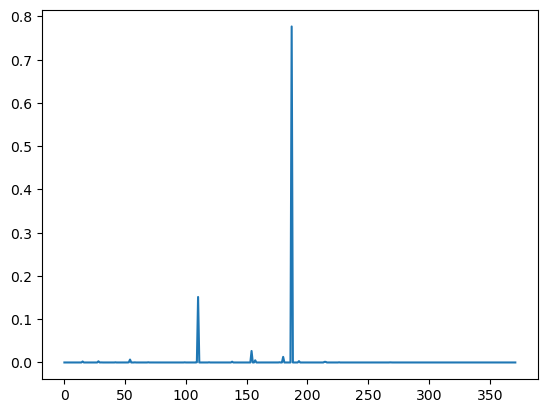

In [77]:
plt.plot(val_predicted_probs_genus[1000].cpu())


# Secondo top2 method

In [84]:
tprs = []
fprs = []
correct_genus_rate = []
correct_species_rate = []
thresholds = []
possible_thresholds = [x / 10000 for x in range(9800, 10000, 1)]
for t in possible_thresholds:#ATTENZIONE QUA E' DIVERSO
    t = t * 1.005
    thresholds.append(t)
    #print(val_predicted_probs.shape)
    n_undescribed_samples = 0
    n_described_samples = 0
    n_correct_undescribed_samples = 0
    n_correct_described_samples = 0
    n_correct_genus = 0 
    n_correct_species = 0 
    for i in range(len(image_val_labels)):
        label_best_specie = val_predicted_labels[i]
       
        #assert(val_predicted_labels[i]==val_predicted_probs[i].argmax())
        genus_of_best_species = species2genus[label_best_specie.item()]

        top2 = torch.tensor(val_predicted_probs[i]).topk(2)#ATTENZIONE QUA E' DIVERSO
        #print(top2)
        if (top2.values[0]-top2.values[1]) >t*top2.values[0]:#species 
            if image_val_labels[i].item() in described_species_labels:#i needed to guess species
                n_described_samples +=1
                if label_best_specie == image_val_labels[i]:#guessed species is correct
                    #n_correct_described_samples+=1
                    n_correct_species+=1
            else:# i needed to guess genus
                n_undescribed_samples+=1
        else:#genus
            if image_val_labels[i].item() in described_species_labels:#i needed to guess species
                n_described_samples +=1
            else:# i needed to guess genus
                n_undescribed_samples+=1
                #if genus_of_best_species == species2genus[image_val_labels[i]]:#guessed genus is correct
                #ATTENZIONE QUA E' DIVERSO
                if val_predicted_labels_genus[i].item() == species2genus[image_val_labels[i]].item():#guessed genus is correct
                    #n_correct_described_samples+=1
                    n_correct_genus+=1
            
    tprs.append(n_correct_undescribed_samples/n_undescribed_samples) # TPR = recall = sensitivity
    fprs.append(1-n_correct_described_samples/n_described_samples) # 1-TNR = 1 - specificity
    correct_genus_rate.append(n_correct_genus/n_undescribed_samples)
    correct_species_rate.append(n_correct_species/n_described_samples)

/tmp/ipykernel_115766/3867016436.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top2 = torch.tensor(val_predicted_probs[i]).topk(2)#ATTENZIONE QUA E' DIVERSO


In [85]:
for index in range(0,len(correct_genus_rate),1):
    print(index)
    print(correct_genus_rate[index])
    print(correct_species_rate[index])
    print('\n\n')

0
0.6847621607094867
0.9616573902288188



1
0.6852996506315506
0.9616573902288188



2
0.6858371405536147
0.9616573902288188



3
0.6863746304756786
0.9616573902288188



4
0.6877183552808385
0.9616573902288188



5
0.6885245901639344
0.9616573902288188



6
0.6901370599301263
0.96134817563389



7
0.6906745498521902
0.96134817563389



8
0.6917495296963182
0.96134817563389



9
0.6922870196183821
0.96134817563389



10
0.6933619994625101
0.96134817563389



11
0.69470572426767
0.96134817563389



12
0.6952432141897339
0.96134817563389



13
0.6957807041117979
0.96134817563389



14
0.6963181940338619
0.96134817563389



15
0.6971244289169578
0.96134817563389



16
0.6976619188390217
0.96134817563389



17
0.6979306638000538
0.96134817563389



18
0.6981994087610858
0.96134817563389



19
0.6987368986831497
0.96134817563389



20
0.6995431335662456
0.96134817563389



21
0.7006181134103736
0.96134817563389



22
0.7016930932545015
0.96134817563389



23
0.7024993281375974
0.9613481756

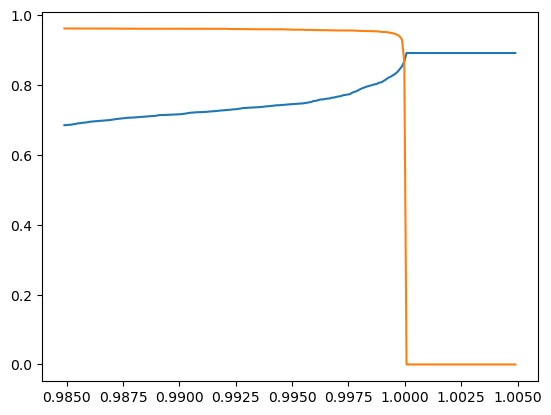

In [86]:
plt.plot(thresholds,correct_genus_rate[-200:])
plt.plot(thresholds,correct_species_rate[-200:])

In [87]:
thresholds[147]

0.9996734999999999

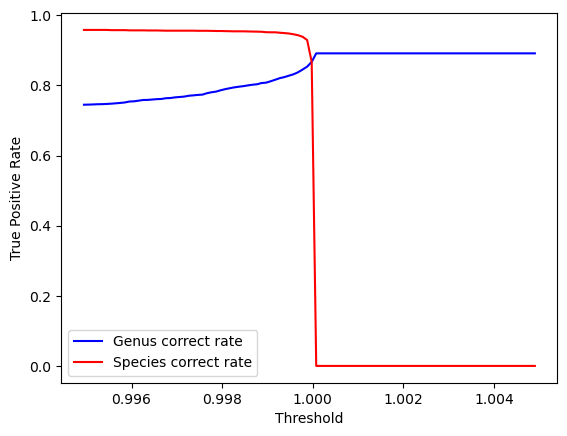

In [88]:
plt.plot(thresholds[-100:], correct_genus_rate[-100:], "-b", label="Genus correct rate")
plt.plot(thresholds[-100:], correct_species_rate[-100:], "-r", label="Species correct rate")

plt.xlabel("Threshold")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig("GenusSpeciesCorrectRate.png")

In [83]:
thresholds[88]

0.8932439999999999

# Random Forest

In [20]:
clf = RandomForestClassifier(min_samples_leaf=2,n_jobs=-1)
clf = clf.fit(complete_train_features_scaled, image_train_labels)

train_predicted_labels = clf.predict(complete_train_features_scaled)
print('train')
val_predicted_labels= clf.predict(complete_val_features_scaled)
print('val')
temp_val_predicted_probs = clf.predict_proba(complete_val_features_scaled)
print('proba')
val_predicted_probs = np.zeros((len(temp_val_predicted_probs),n_classes))
for i, cls in enumerate(np.arange(n_classes)):
    if cls in clf.classes_:
        val_predicted_probs[:, cls] = temp_val_predicted_probs[:, list(clf.classes_).index(cls)]

train
val
proba


In [21]:
temp_val_predicted_probs

array([[0.        , 0.89183333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.90766667, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.7425    , ..., 0.        , 0.01      ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.8675    ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.9625    ]])

In [22]:
feature_importances = clf.feature_importances_
feature_importances

array([0.00012523, 0.00010174, 0.00011856, ..., 0.        , 0.        ,
       0.        ])

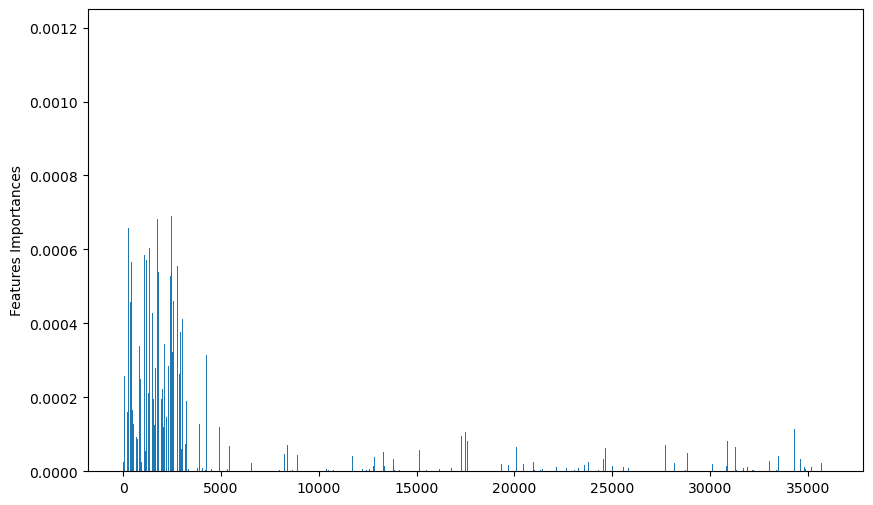

In [23]:
feature_names = [f'Feature {i+1}' for i in range(complete_train_features.shape[1])]

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, align='center')
plt.ylabel('Features Importances')
plt.show()

# Accuracies

In [24]:
print(f"Training species accuracy:{np.count_nonzero(train_predicted_labels==image_train_labels.numpy())/len(image_train_labels)}")

print(f"Validation species accuracy:{np.count_nonzero(val_predicted_labels==image_val_labels.numpy())/len(image_val_labels)}")

Training species accuracy:0.9999233070020707
Validation species accuracy:0.45751258087706687


In [25]:
import math
n_correct_genus = 0
for i in range(len(image_val_labels)):
    #label_best_specie = val_predicted_probs[i].argmax()
    label_best_specie = val_predicted_labels[i]
    #print(val_predicted_labels[i])
    #print(val_predicted_probs[i].argmax())
    #assert(val_predicted_labels[i]==val_predicted_probs[i].argmax())
    genus_of_best_species = species2genus[label_best_specie.item()]
    #species_same_genus = [k for k,v in species2genus.items() if v == genus_of_best_species]
    #reduced_species = val_predicted_probs[i][species_same_genus]
    #normalized_reduced_species = reduced_species/(reduced_species.sum())
    
    real_genus = species2genus[image_val_labels[i].item()]
    predicted_genus = genus_of_best_species
    if real_genus == predicted_genus:
        n_correct_genus+=1
print(f"Validation genus accuracy: {n_correct_genus/len(image_val_labels)}")

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [26]:
val_predicted_labels_genus[i]

tensor(366)

0
0.0
0.9904666332162569



1
0.004448210124973522
0.9904666332162569



2
0.009425969074348655
0.9904666332162569



3
0.013238720610040246
0.9904666332162569



4
0.01779284049989409
0.9904666332162569



5
0.02160559203558568
0.9904666332162569



6
0.025630163101037915
0.9904666332162569



7
0.030502012285532724
0.9904666332162569



8
0.03526795170514722
0.9904666332162569



9
0.039504342300360096
0.9902157551430005



10
0.04363482313069265
0.9902157551430005



11
0.047553484431264566
0.9902157551430005



12
0.05242533361575937
0.9902157551430005



13
0.05708536327049354
0.9902157551430005



14
0.06163948316034738
0.9902157551430005



15
0.06619360305020122
0.9902157551430005



16
0.0699004448210125
0.9902157551430005



17
0.07487820377038763
0.9902157551430005



18
0.08027960177928405
0.9902157551430005



19
0.08652827790722305
0.9902157551430005



20
0.09087057826731625
0.9902157551430005



21
0.09563651768693074
0.9902157551430005



22
0.10040245710654522
0.99021

# Top-2 Method

In [31]:
tprs = []
fprs = []
correct_genus_rate = []
correct_species_rate = []
for t in range(0,100,1):
    entropy_threshold = t/100.0
    #print(val_predicted_probs.shape)
    n_undescribed_samples = 0
    n_described_samples = 0
    n_correct_undescribed_samples = 0
    n_correct_described_samples = 0
    n_correct_genus = 0 
    n_correct_species = 0 
    for i in range(len(image_val_labels)):
        
        label_best_specie = val_predicted_labels[i]
       
        #assert(val_predicted_labels[i]==val_predicted_probs[i].argmax())
        genus_of_best_species = species2genus[label_best_specie.item()]
        
        sorted_probs = np.sort(val_predicted_probs[i])
        sorted_probs = sorted_probs[::-1]
        
        prob_diff = abs(sorted_probs[0] - sorted_probs[1])
        #print(prob_diff)
        if image_val_labels[i].item() in described_species_labels:
            #tn
            n_described_samples +=1
            if prob_diff >= entropy_threshold:
                n_correct_described_samples+=1
                if label_best_specie == image_val_labels[i]:
                    n_correct_species+=1
        else:
            #tp
            n_undescribed_samples+=1
            if prob_diff < entropy_threshold:
                n_correct_undescribed_samples+=1
                real_genus = species2genus[image_val_labels[i].item()]
                predicted_genus = genus_of_best_species
                if real_genus == predicted_genus:
                    n_correct_genus+=1
        
            
    tprs.append(n_correct_undescribed_samples/n_undescribed_samples) # TPR = recall = sensitivity
    fprs.append(1-n_correct_described_samples/n_described_samples) # 1-TNR = 1 - specificity
    correct_genus_rate.append(n_correct_genus/n_undescribed_samples)
    correct_species_rate.append(n_correct_species/n_described_samples)

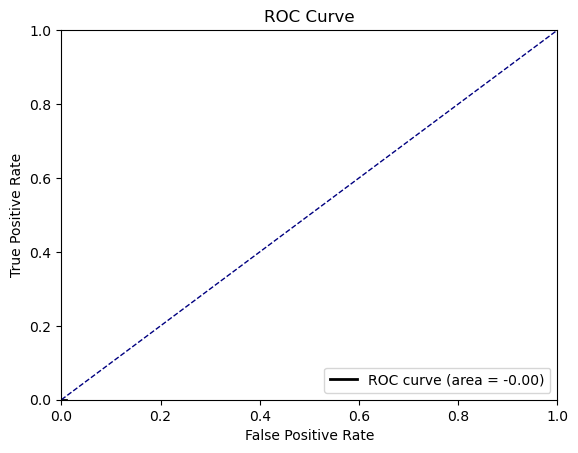

In [42]:
from sklearn.metrics import roc_curve, auc

roc_auc = auc(fprs, tprs)

plt.figure()
plt.plot(fprs, tprs, color='black', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

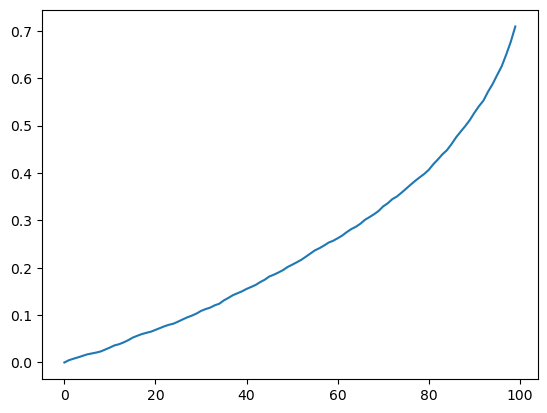

In [52]:
plt.plot(correct_genus_rate)

0.04986902625680434


Text(0, 0.5, 'Correct Genus Rate')

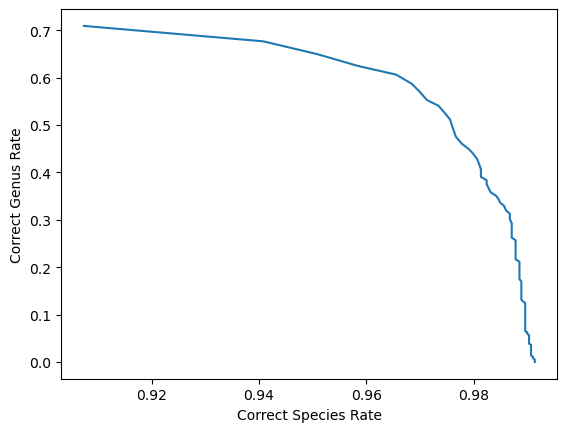

In [53]:
area_correct = auc(correct_species_rate,correct_genus_rate)
print(area_correct)

plt.plot(correct_species_rate,correct_genus_rate)
plt.xlabel("Correct Species Rate")
plt.ylabel("Correct Genus Rate")

In [54]:
for index in range(0,100,1):
    print(index)
    print(correct_genus_rate[index])
    print(correct_species_rate[index])
    print('\n\n')

0
0.0
0.9913854989231874



1
0.004815795810257645
0.9913854989231874



2
0.007946063086925114
0.9910265613783201



3
0.010835540573079701
0.9910265613783201



4
0.01396580784974717
0.990667623833453



5
0.01709607512641464
0.990667623833453



6
0.019022393450517698
0.990667623833453



7
0.020948711774620755
0.990667623833453



8
0.02335660967974958
0.990667623833453



9
0.027450036118468576
0.990667623833453



10
0.031543462557187575
0.990667623833453



11
0.036118468576932336
0.990667623833453



12
0.03852636648206116
0.9903086862885858



13
0.042379003130267275
0.9903086862885858



14
0.04695400915001204
0.9903086862885858



15
0.05249217433180833
0.9903086862885858



16
0.05634481098001445
0.9903086862885858



17
0.059956657837707684
0.9899497487437185



18
0.06260534553334939
0.9899497487437185



19
0.06501324343847821
0.9895908111988514



20
0.06886588008668433
0.9895908111988514



21
0.07271851673489044
0.9895908111988514



22
0.07657115338309656
0.989590811

In [56]:
print(correct_genus_rate[50])
correct_species_rate[50]

0.20635685046954008


0.9885139985642498